# Lab 7: Regression

Welcome to Lab 7!

Today we will get some hands-on practice with linear regression. You can find more information about this topic in
[section 13.2](http://www.inferentialthinking.com/chapters/13/2/regression-line.html).

#### Administrative details
Lab submissions are due by **Friday, November 4 at 7:00 PM**.  Remember to submit your lab by running all the tests and then running the final cell in the lab.

In [2]:
# Run this cell, but please don't change it.

# These lines import the Numpy and Datascience modules.
import numpy as np
from datascience import *

# These lines do some fancy plotting magic.
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import warnings
warnings.simplefilter('ignore', FutureWarning)

# These lines load the tests.
from client.api.assignment import load_assignment
tests = load_assignment('lab07.ok')

ModuleNotFoundError: No module named 'client'

# 1. How Faithful is Old Faithful? 

(Note: clever title comes from [here](http://web.pdx.edu/~jfreder/M212/oldfaithful.pdf).)

Old Faithful is a geyser in Yellowstone National Park in the central United States.  It's famous for erupting on a fairly regular schedule.  You can see a video below.

In [3]:
# For the curious: this is how to display a YouTube video in a
# Jupyter notebook.  The argument to YouTubeVideo is the part
# of the URL (called a "query parameter") that identifies the
# video.  For example, the full URL for this video is:
#   https://www.youtube.com/watch?v=wE8NDuzt8eg
from IPython.display import YouTubeVideo
YouTubeVideo("wE8NDuzt8eg")

Some of Old Faithful's eruptions last longer than others.  When it has a long eruption, there's generally a longer wait until the next eruption.

If you visit Yellowstone, you might want to predict when the next eruption will happen, so you can see the rest of the park and come to see the geyser when it happens.  Today, we will use a dataset on eruption durations and waiting times to see if we can make such predictions accurately with linear regression.

The dataset has one row for each observed eruption.  It includes the following columns:
- **duration**: Eruption duration, in minutes
- **wait**: Time between this eruption and the next, also in minutes

Run the next cell to load the dataset.

In [4]:
faithful = Table.read_table("faithful.csv")
faithful

duration,wait
3.6,79
1.8,54
3.333,74
2.283,62
4.533,85
2.883,55
4.7,88
3.6,85
1.95,51
4.35,85


We would like to use linear regression to make predictions, but that won't work well if the data aren't roughly linearly related.  To check that, we should look at the data.

#### Question 1
Make a scatter plot of the data.  It's conventional to put the column we will try to predict on the vertical axis and the other column on the horizontal axis.

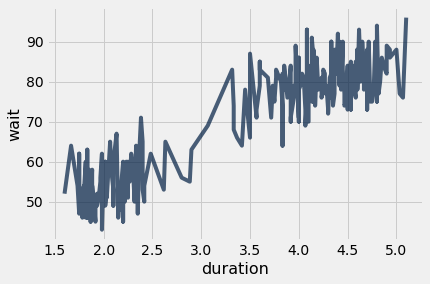

In [5]:
faithful.plot('duration', 'wait')

#### Question 2
Look at the scatter plot. Are eruption duration and waiting time roughly linearly related?  Is the relationship positive, as we claimed earlier?  You may want to consult [the textbook chapter 13](https://www.inferentialthinking.com/chapters/13/prediction.html) for the definition of "linearly related."

### Ans:
Despite fluctuating, the data look like it would follow a straight line with a positive slope. 

We're going to continue with the provisional assumption that they are linearly related, so it's reasonable to use linear regression to analyze this data.

We'd next like to plot the data in standard units.  Recall that, if `nums` is an array of numbers, then

    (nums - np.mean(nums)) / np.std(nums)

...is an array of those numbers in standard units.

#### Question 3
Compute the mean and standard deviation of the eruption durations and waiting times.  **Then** create a table called `faithful_standard` containing the eruption durations and waiting times in standard units.  (The columns should be named `"duration (standard units)"` and `"wait (standard units)"`.

In [6]:
faithful

duration,wait
3.6,79
1.8,54
3.333,74
2.283,62
4.533,85
2.883,55
4.7,88
3.6,85
1.95,51
4.35,85


In [10]:
duration_mean = np.mean(faithful.column('duration'))
duration_std = np.std(faithful.column('duration'))
wait_mean = np.mean(faithful.column('wait'))
wait_std = np.std(faithful.column('wait'))

faithful_standard = Table().with_columns(
    "duration (standard units)", (faithful.column('duration') - duration_mean) / duration_std,
    "wait (standard units)", (faithful.column('wait') - wait_mean) / wait_std)
faithful_standard

duration (standard units),wait (standard units)
0.0984989,0.597123
-1.48146,-1.24518
-0.135861,0.228663
-1.0575,-0.655644
0.917443,1.03928
-0.530851,-1.17149
1.06403,1.26035
0.0984989,1.03928
-1.3498,-1.46626
0.756814,1.03928


In [8]:
_ = tests.grade('q1_3')

NameError: name 'tests' is not defined

#### Question 4
Plot the data again, but this time in standard units.

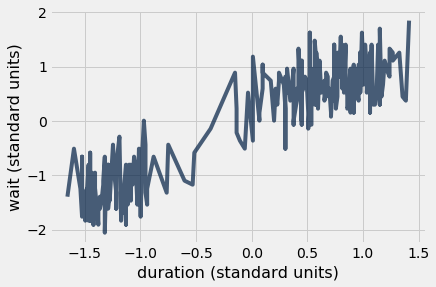

In [12]:
faithful_standard.plot(0, 1)

You'll notice that this plot looks exactly the same as the last one!  The data really are different, but the axes are scaled differently.  (The method `scatter` scales the axes so the data fill up the available space.)  So it's important to read the ticks on the axes.

#### Question 5
Among the following numbers, which would you guess is closest to the correlation between eruption duration and waiting time in this dataset?

* -1
* 0
* 1

### Ans:
`1`, because the linear relationship of the data looks like it will follow a straight line with positive slope. 

#### Question 6
Compute the correlation `r`.  *Hint:* Use `faithful_standard`.  Section [13.1](https://www.inferentialthinking.com/chapters/13/1/correlation.html) explains how to do this.

In [13]:
r = np.mean(faithful_standard.column(0) * faithful_standard.column(1))
r

0.9008111683218132

In [ ]:
_ = tests.grade('q1_6')

## 2. The regression line
Recall that the correlation is the slope of the regression line when the data are put in standard units.

The next cell plots the regression line in standard units:

$$\text{waiting time (standard units)} = r \times \text{eruption duration (standard units)}.$$

Then, it plots the original data again, for comparison.

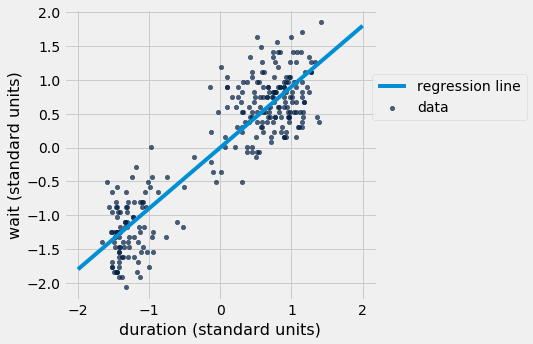

In [14]:
def plot_data_and_line(dataset, x, y, point_0, point_1):
    """Makes a scatter plot of the dataset, along with a line passing through two points."""
    dataset.scatter(x, y, label="data")
    plt.plot(make_array(point_0.item(0), point_1.item(0)), make_array(point_0.item(1), point_1.item(1)), label="regression line")
    plt.legend(bbox_to_anchor=(1.5,.8))

plot_data_and_line(faithful_standard, "duration (standard units)", "wait (standard units)", make_array(-2, -2*r), make_array(2, 2*r))

How would you take a point in standard units and convert it back to original units?  We'd have to "stretch" its horizontal position by `duration_std` and its vertical position by `wait_std`.

That means the same thing would happen to the slope of the line.

Stretching a line horizontally makes it less steep, so we divide the slope by the stretching factor.  Stretching a line vertically makes it more steep, so we multiply the slope by the stretching factor.

#### Question 1
What is the slope of the regression line in original units?

(If the "stretching" explanation is unintuitive, consult section [13.2](https://www.inferentialthinking.com/chapters/13/2/regression-line.html) in the textbook.)

In [15]:
slope = r * wait_std / duration_std
slope


10.729641395133529

We know that the regression line passes through the point `(duration_mean, wait_mean)`.  You might recall from high-school algebra that the equation for the line is therefore:

$$\text{waiting time} - \verb|wait_mean| = \texttt{slope} \times (\text{eruption duration} - \verb|duration_mean|)$$

After rearranging that equation slightly, the intercept turns out to be:

In [16]:
intercept = slope*(-duration_mean) + wait_mean
intercept


33.474397022753344

In [ ]:
_ = tests.grade('q2_1')

## 3. Investigating the regression line
The slope and intercept tell you exactly what the regression line looks like.  To predict the waiting time for an eruption, multiply the eruption's duration by `slope` and then add `intercept`.

#### Question 1
Compute the predicted waiting time for an eruption that lasts 2 minutes, and for an eruption that lasts 5 minutes.

In [ ]:
two_minute_predicted_waiting_time = ...
five_minute_predicted_waiting_time = ...

# Here is a helper function to print out your predictions
# (you don't need to modify it):
def print_prediction(duration, predicted_waiting_time):
    print("After an eruption lasting", duration,
          "minutes, we predict you'll wait", predicted_waiting_time,
          "minutes until the next eruption.")

print_prediction(2, two_minute_predicted_waiting_time)
print_prediction(5, five_minute_predicted_waiting_time)

The next cell plots the line that goes between those two points, which is (a segment of) the regression line.

In [ ]:
plot_data_and_line(faithful, "duration", "wait", make_array(2, two_minute_predicted_waiting_time), make_array(5, five_minute_predicted_waiting_time))

#### Question 2
Make predictions for the waiting time after each eruption in the `faithful` table.  (Of course, we know exactly what the waiting times were!  We are doing this so we can see how accurate our predictions are.)  Put these numbers into a column in a new table called `faithful_predictions`.  Its first row should look like this:

|duration|wait|predicted wait|
|-|-|-|
|3.6|79|72.1011|

*Hint:* Your answer can be just one line.  There is no need for a `for` loop; use array arithmetic instead.

In [ ]:
faithful_predictions = ...
faithful_predictions

In [ ]:
_ = tests.grade("q3_2")

#### Question 3
How close were we?  Compute the *residual* for each eruption in the dataset.  The residual is the difference (not the absolute difference) between the actual waiting time and the predicted waiting time.  Add the residuals to `faithful_predictions` as a new column called `"residual"`, naming the resulting table `faithful_residuals`.

*Hint:* Again, your code will be much simpler if you don't use a `for` loop.

In [ ]:
faithful_residuals = ...
faithful_residuals

In [ ]:
_ = tests.grade("q3_3")

Here is a plot of the residuals you computed.  Each point corresponds to one eruption.  It shows how much our prediction over- or under-estimated the waiting time.

In [ ]:
faithful_residuals.scatter("duration", "residual", color="r")

There isn't really a pattern in the residuals, which confirms that it was reasonable to try linear regression.  It's true that there are two separate clouds; the eruption durations seemed to fall into two distinct clusters.  But that's just a pattern in the eruption durations, not a pattern in the relationship between eruption durations and waiting times.

## 4. How accurate are different predictions?
Earlier, you should have found that the correlation is fairly close to 1, so the line fits fairly well on the training data.  That means the residuals are overall small (close to 0) in comparison to the waiting times.

We can see that visually by plotting the waiting times and residuals together:

In [ ]:
faithful_residuals.scatter("duration", "wait", label="actual waiting time", color="blue")
plt.scatter(faithful_residuals.column("duration"), faithful_residuals.column("residual"), label="residual", color="r")
plt.plot(make_array(2, 5), make_array(two_minute_predicted_waiting_time, five_minute_predicted_waiting_time), label="regression line")
plt.legend(bbox_to_anchor=(1.7,.8));

However, unless you have a strong reason to believe that the linear regression model is true, you should be wary of applying your prediction model to data that are very different from the training data.

#### Question 1
In `faithful`, no eruption lasted exactly 0, 2.5, or 60 minutes.  Using this line, what is the predicted waiting time for an eruption that lasts 0 minutes?  2.5 minutes?  An hour?

In [ ]:
zero_minute_predicted_waiting_time = ...
two_point_five_minute_predicted_waiting_time = ...
hour_predicted_waiting_time = ...

print_prediction(0, zero_minute_predicted_waiting_time)
print_prediction(2.5, two_point_five_minute_predicted_waiting_time)
print_prediction(60, hour_predicted_waiting_time)

In [ ]:
_ = tests.grade('q4_1')

**Question 2.** Do you believe any of these values are reliable predictions?  If you don't believe some of them, say why.

*Write your answer here, replacing this text.*

In [ ]:
# For your convenience, you can run this cell to run all the tests at once!
import os
print("Running all tests...")
_ = [tests.grade(q[:-3]) for q in os.listdir("tests") if q.startswith('q')]
print("Finished running all tests.")

In [ ]:
# Run this cell to submit your work *after* you have passed all of the test cells.
# It's ok to run this cell multiple times. Only your final submission will be scored.

!TZ=America/Los_Angeles jupyter nbconvert --output=".lab07_$(date +%m%d_%H%M)_submission.html" lab07.ipynb && echo "Submitted successfully."